In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [15]:
def calculate_kup1_rsi_enhanced_v5(df, rsi_window=14):
    # 计算基础因子
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    overbought = np.where(df['rsi'] > 70, 1.5, 0.5)
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    base_kup1 = upper_shadow / df['open']
    factor = base_kup1 * overbought
    
    # 动态阈值尾部优化
    # 使用滚动窗口计算动态阈值
    rolling_quantile = factor.rolling(1000).quantile(0.15)
    rolling_std = factor.rolling(1000).std()
    
    # 尾部信号识别与强化
    tail_condition = factor < rolling_quantile
    enhanced_factor = np.where(
        tail_condition,
        factor - 2 * rolling_std,
        factor
    )
    
    return enhanced_factor

# 因子测试

In [16]:
evaluator.set_factor(
    factor_func=calculate_kup1_rsi_enhanced_v5,
    factor_name='calculate_kup1_rsi_enhanced_v5'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.010531
   Rank_IC (Spearman): 0.010144
📊 信息比率:
   IR: -0.429573
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130511
   因子列: calculate_kup1_rsi_enhanced_v5
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


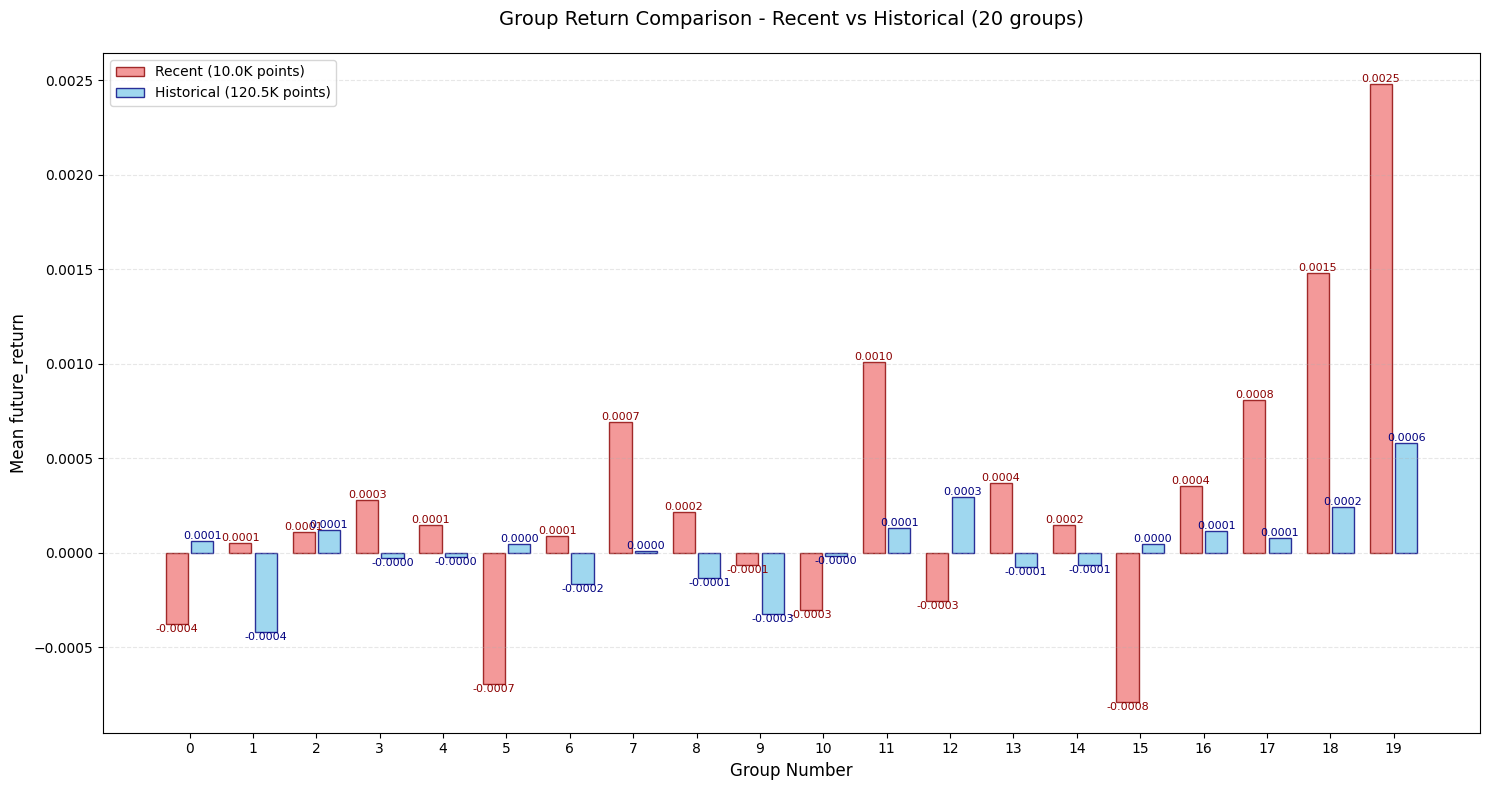

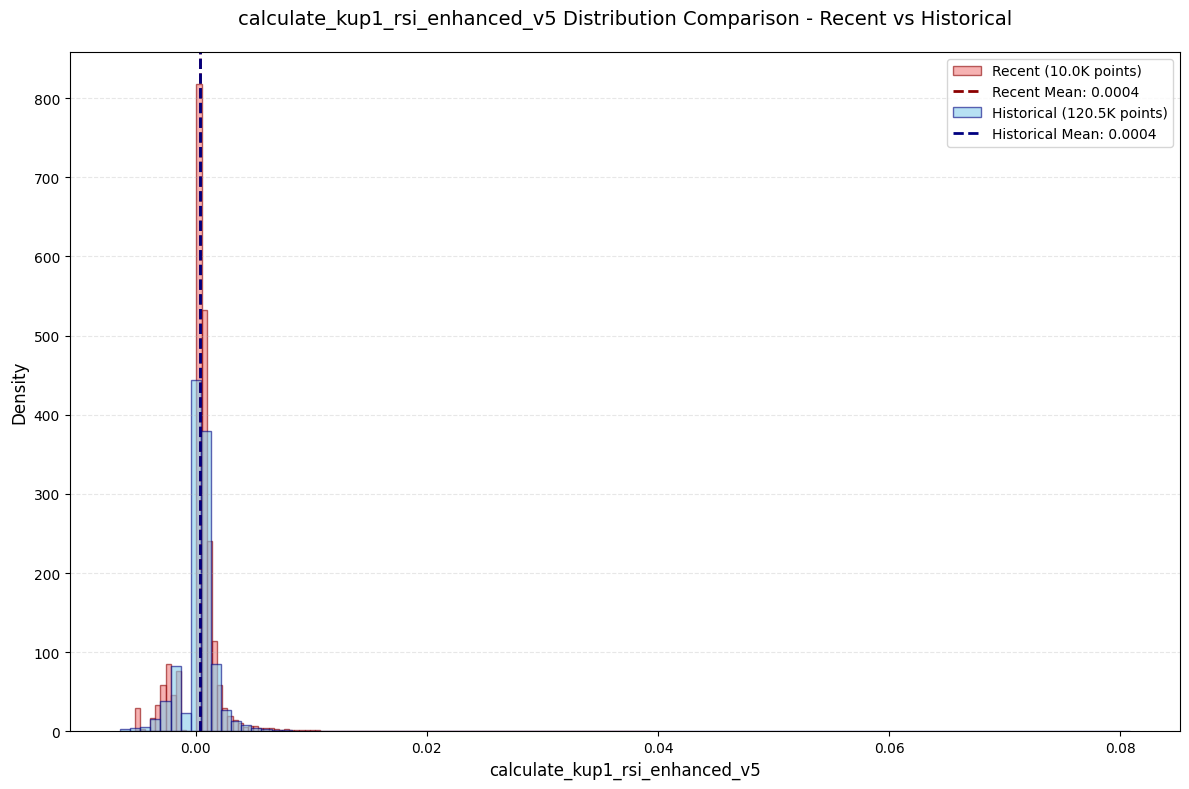

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [17]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)